# Tweet sentiment analysis

In [81]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import boto3
import s3fs
%matplotlib inline
plt.style.use('seaborn-dark')
pd.set_option('display.max_colwidth', -1)

## Get dataframe from S3 bucket

In [3]:
# # Read CSV file
# #tweets_today = pd.read_csv(r"..\datasets\raw_data\tweets{}.csv".format(datetime.date.today()))
# tweets_today = pd.read_csv(r"..\datasets\raw_data\tweets2019-10-08.csv")
# tweets_today = tweets_today.head(5000)
# # Gets tweet texts
# tweets_today_text = tweets_today["tweet"]
bucketname = 'ops-vw-interns-climate-perception-tweets'
dataframe = pd.DataFrame(columns=("creation date","keyword", "tweet", 
                                  "username"))
s3 = boto3.resource("s3")

s3_tweets = s3.Bucket(bucketname).objects.all()
print("Objects in S3 bucket: ")
for file in s3_tweets:
    temp_df = pd.read_json('s3://{}/{}'.format(bucketname, file.key))
    dataframe = dataframe.append(temp_df, sort=False, ignore_index=True)
    print("\t"+file.key)

dataframe_tweets = dataframe["tweet"]
print("Amount of tweets in dataset: "+str(len(dataframe)))

Objects in S3 bucket: 
	tweets2019-10-10.json
	tweets2019-10-12.json
	tweets2019-10-13.json
	tweets2019-10-14.json
	tweets2019-10-15.json
	tweets2019-10-16.json
	tweets2019-10-17.json
Amount of tweets in dataset: 6244


## Data cleaning

In [4]:
# Preprocessing of tweet texts
def format_tweet(tweet):
    processed_tweet=""
    for word in tweet.split():
        # Removing URL from tweet
        processed_word = re.sub('([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', word)
        # remove all single characters
        processed_word = re.sub('\s+[a-zA-Z]\s+', ' ', processed_word)
        # Remove single characters from the start
        processed_word = re.sub('\^[a-zA-Z]\s+', ' ', processed_word) 
        # Substituting multiple spaces with single space
        processed_word = re.sub('\s+', '', processed_word, flags=re.I)
        # Removing prefixed 'b'
        processed_word = re.sub('^b\s+', ' ', processed_word)
        # Removing &amp
        processed_word = re.sub('&amp', '&', processed_word)
        # Removing breaks
        processed_word = re.sub('<br/>', '', processed_word)
        # converts to lower
        processed_word = processed_word.lower()
        processed_tweet= processed_tweet+" "+processed_word
    return processed_tweet        
    
tweets_text = [format_tweet(tweet) for tweet in dataframe_tweets]
tweets_text = list(filter(None, tweets_text))

for i, tweet in enumerate(tweets_text[50:60]):
    print(str(i)+tweet + "\n")


0 climate change evidence how do we know gt vital signs of the planet global climate change and global warming how do we know its happening heres the evidence 

1 the election debate is over stay on the track libs mistakes in four years must not be hidden apologized snc lavalin climate change vs pipeline international relations economy down huge deficit list goes on never repeated libs must go say no to libs vote no 

2 revealed google made large contributions to climate change deniers 

3 climate change the devastating effect plastics have on our oceans dwindling numbers of rare species nah 

4 pieces of junk toplevel japanese climate scientist rejects global warming panic  opinion  lifesite 

5 the simpsons predicted greta thunbergs climate change speech in 2007  nme 

6 aoc gets choked up at climate forum my dreams of motherhood are now bittersweet  please do not procreate draintheswamp walkawayfromdemocratsocialists

7 climatechange protesters hold london funeral march 

8 im not t

## Labeling tweets with NLTK vader

In [5]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ViMs\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
sid = SentimentIntensityAnalyzer()

for i, tweet in enumerate(tweets_text[50:60]):
    print("{0}:{1} \n{2}\n\n".format(i, tweet, sid.polarity_scores(tweet)))

0: climate change evidence how do we know gt vital signs of the planet global climate change and global warming how do we know its happening heres the evidence  
{'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'compound': 0.5994}


1: the election debate is over stay on the track libs mistakes in four years must not be hidden apologized snc lavalin climate change vs pipeline international relations economy down huge deficit list goes on never repeated libs must go say no to libs vote no  
{'neg': 0.219, 'neu': 0.738, 'pos': 0.044, 'compound': -0.8054}


2: revealed google made large contributions to climate change deniers  
{'neg': 0.208, 'neu': 0.792, 'pos': 0.0, 'compound': -0.2732}


3: climate change the devastating effect plastics have on our oceans dwindling numbers of rare species nah  
{'neg': 0.289, 'neu': 0.711, 'pos': 0.0, 'compound': -0.6908}


4: pieces of junk toplevel japanese climate scientist rejects global warming panic  opinion  lifesite  
{'neg': 0.359, 'neu': 0.552, 'pos'

In [7]:
def get_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    if polarity == 0:
        return 'neutral'
    else:
        return 'negative'

word_count = [len(tweet) for tweet in tweets_text]
    
polarity_tweets = [round(sid.polarity_scores(tweet)["compound"], 2)
                   for tweet in tweets_text]

sentiment_tweets = [get_sentiment(polarity) for polarity in polarity_tweets]

zipped_list = list(zip(sentiment_tweets, polarity_tweets,
                       tweets_text, word_count, dataframe['keyword'],
                       dataframe['username'], dataframe['creation date']))

# Store to new dataframe with sentiment values and polarities
sentiment_df = pd.DataFrame(zipped_list, 
                            columns=["Sentiment", "Polarity", 
                                     "Tweet", "Word count" "Keyword", "Username", 
                                     "Creation Date"])
sentiment_df.sample(15)

,Sentiment,Polarity,Tweet,Keyword,Username,Creation Date
1610,negative,-0.53,climate change is threatening there are more signs,Climate change,JustinBonanza,2019-10-13 19:36:54
4504,positive,0.95,we are beyond excited to announce our portraitsfromtheprecipice project with octopusenergy a new art prize to raise awareness of climatechange first prize 10000 please share please join please enter art by erikbrede artforclimate,Climate change,Artfinder,2019-10-17 08:45:25
2004,negative,-0.94,it doesnt hurt as much when someone dies because of an accident or a natural disaster i know theyre worse bc of climate change but when someone dies of something that couldve possibly been avoided like a curable disease or a suicide thats when it really pains me,Climate change,ᴄʀʏʙᴀʙʏ,2019-10-14 20:20:24
2159,positive,0.85,proud moment today at ustwo nyc we officially created a climate change internal project in our system creating a safe space for us to do climate change related work and being able to log our hours more to come climatechange,Climate change,Juan Cabrera,2019-10-14 20:05:29
1867,negative,-0.77,without significant climate change mitigation about 60 percent of the worlds wheatgrowing areas will suffer from simultaneous severe and prolonged droughts,Climate change,Fede G. de Miguel,2019-10-14 20:33:44
5788,positive,0.27,keep nuclear in the energy mix to tackle climate change ieas birol,Climate change,News Finance,2019-10-17 07:03:19
5105,negative,-0.93,how to fuck off 7million people and turn them away from climate change and protesting for change mess up their already shitty london commute for no reason extinctionrebelion the tube is electriclondon buses are gaselectric crustyjugglers mindthegap,Climate change,Mr Testicles,2019-10-17 07:56:10
1520,positive,0.50,there has never been a greater time to switch to renewable energy than at this great time where climate change threatens our very existence e advocacy greenampinclusiveenergy hivosrosa hivosenergy hivosroea,Climate change,RopafadzoSandra Shoko,2019-10-13 19:48:00
977,positive,0.62,great to see jasonfalinskimp in this fed parliament group calling for action on climate change instead of political point scoring,Climate change,"Alan ""The Nice One"" Jones",2019-10-13 20:44:20
4737,positive,0.67,you only have one week left to let us know your thoughts on our climate change strategy we want to hear your ideas so we can make it the best it can be have your say today richmondclimateaction bethechange actonclimate communityconversation,Climate change,Richmond Council,2019-10-17 08:25:11


In [8]:
print("5 most negative tweets: \n")
top5_negative = pd.DataFrame(sentiment_df.sort_values("Polarity")[["Tweet","Polarity"]].head(5))
top5_negative

5 most negative tweets: 



,Tweet,Polarity
5475,what a bunch of fuckin bullshit yesterday at this time it was 64 and today its 81 so now im just laying in a puddle of my own sweat in bed fuck arizona fuck this heat fuck ac costs fuck china fuck you fuck your climate change get fucked rot and die im sick and tired of arizona,-0.99
3882,this is literally worse than isis terrorism racism homophobia sexism cancer global warming poverty world hunger israel war drug addiction the prison system police animal abuse pollution murder sexual abuse violence zionism depression mass shootings,-0.99
5525,labor says treat drought like war but keep burning all that coal and gas which makes climate change worse which makes droughts worse youll never win a war if you keep supplying the enemy with the ammunition they need to defeat you thedrum,-0.98
1016,conflicts of interest treason rape sexual assault sexual predator tax evasion campaign finance fraud money laundering collusion crimes against humanity bribery war crimes against climate change habitual liar philanderer illiterate impeachandremove,-0.97
1932,lets get the record straight you employ a massive racist sexist homophobic global warming denier and criminal who takes the piss out of a 16 year old with aspergers because she doesnt want the planet to die so fuck off with ur shitty poll gmb,-0.97


In [9]:
print("5 most positive tweets: \n")
top5_positive = sentiment_df.sort_values("Polarity", ascending=False)[["Tweet", "Polarity"]].head(5)
top5_positive

5 most positive tweets: 



,Tweet,Polarity
3936,i rarely pay attention to will but he wears a sherwani well kate has also looked quite lovely in her outfits by designers i am so glad they are trying to highlight the effects of climate change with their visit and hope both brothers continue using their platforms to do so,0.97
1884,great visit this pm to centrealttech in machynlleth to meet their management team and listen to their exciting and ambitious plans for the future impressive increase in both visitor and student numbers this year hopefully a sign of more interest in climate change perhaps,0.97
3698,climate change aid is also an example of courage commitment and early responsibility that children and women want and can participate in all the tasks that form better human beings better citizens better friendly countries and a resilient planet in health support and admira,0.96
2399,yes good idea i am going to re read too heres 10 to do based on 2 climate change degees free for all their success is mainly due to laudatosi ideally you do one share with your followers how you got on and your thoughts they have long lasting effects,0.95
4504,we are beyond excited to announce our portraitsfromtheprecipice project with octopusenergy a new art prize to raise awareness of climatechange first prize 10000 please share please join please enter art by erikbrede artforclimate,0.95


total positive: 2439
total neutral: 1001
total negative: 2804


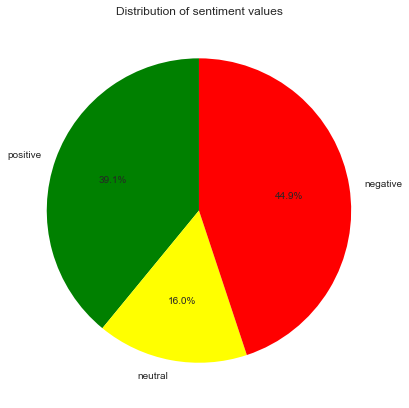

In [63]:
sentiments = [get_sentiment(polarity)
              for polarity in sentiment_df["Polarity"]]

sentiment_count_list = np.array([sentiments.count(
    "positive"), sentiments.count("neutral"), sentiments.count("negative")])

classes = ["positive", "neutral", "negative"]
colors = ["green", "yellow", "red"]

plt.figure(figsize=(7,7))
plt.pie(sentiment_count_list, labels=classes, autopct='%1.1f%%',startangle=90, colors=colors)
plt.title("Distribution of sentiment values")

print("total positive: {}".format(sentiments.count('positive')))

print("total neutral: {}".format(sentiments.count('neutral')))

print("total negative: {}".format(sentiments.count('negative')))

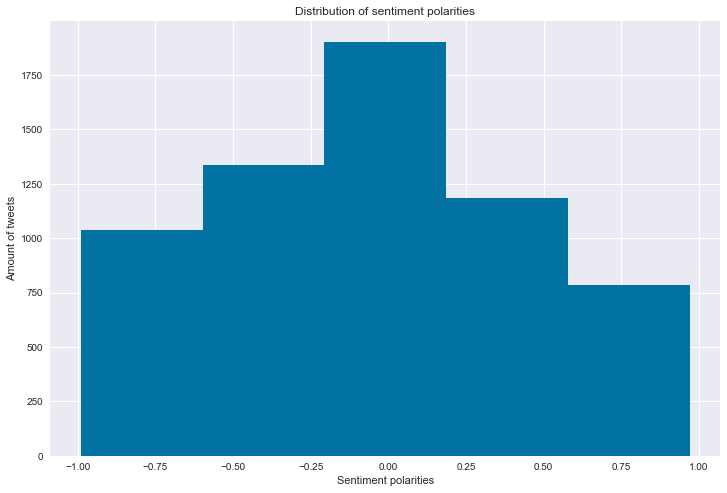

In [40]:
sentiment_df.hist(bins=5, figsize=(12, 8))
plt.title("Distribution of sentiment polarities")
plt.xlabel("Sentiment polarities")
plt.ylabel("Amount of tweets")
plt.show()

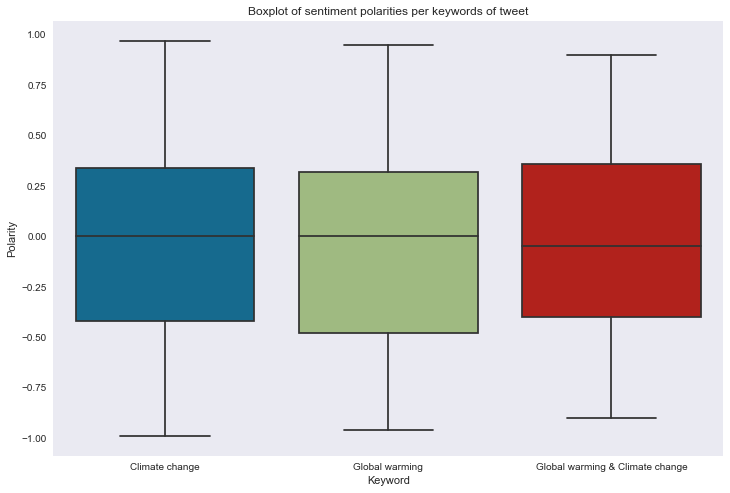

In [41]:
plt.figure(figsize=(12, 8))
sns.boxplot(x=sentiment_df['Keyword'], y=sentiment_df['Polarity'])
plt.title("Boxplot of sentiment polarities per keywords of tweet")
total_cc = sentiment_df[sentiment_df['Keyword'=="Climate change"]].value_counts()
total_gw = sentiment_df[sentiment_df['Keyword'=="Global warming"]].value_counts()
total_ccgw = sentiment_df[sentiment_df['Keyword'=="Global warming & climate change"]].value_counts()

## Implementing machine learning classifiers

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import PorterStemmer
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from yellowbrick.target import ClassBalance

### Divide into training and test sets

In [14]:
from sklearn.model_selectiTfidfTransformer import train_test_split

# Extract features from df
features = sentiment_df["Tweet"]

# Extract labels from df
labels = sentiment_df["Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels, test_size=0.2,
                                                    random_state=1)

print("Training set contains: "+str(len(X_train))+ " samples")
print("Testing set contains: "+str(len(X_test))+ " samples")

Training set contains: 4995 samples
Testing set contains: 1249 samples


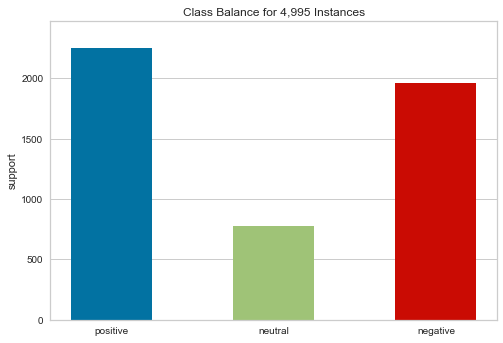

In [34]:
class_balance = ClassBalance(labels=classes)
class_balance.fit(y_train) 
class_balance.show()

### Preparing pipeline variables

In [15]:
count_vec = CountVectorizer(strip_accents=None, lowercase=False, 
                            preprocessor = None)
tfidf = TfidfTransformer()

def tokenizer(text):
    return text.split()

porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

#### Testing tokenizers, vectorizers and transformers

In [16]:
sample_tweet = "Hi i think global warming is awesome. What about you?"

token_list = tokenizer(sample_tweet)

porter_list =tokenizer_porter(sample_tweet)

In [17]:
count_vec.fit(token_list)
print("With normal tokenizer:")
count_vec.vocabulary_

With normal tokenizer:


{'Hi': 0,
 'think': 7,
 'global': 4,
 'warming': 8,
 'is': 6,
 'awesome': 3,
 'What': 1,
 'about': 2,
 'yourself': 9,
 'horrible': 5}

In [138]:
count_vec.fit(token_list)
tfidf.transform(count_vec)
print("With normal tokenizer:")
count_vec.vocabulary_

TypeError: float() argument must be a string or a number, not 'CountVectorizer'

In [18]:
count_vec.fit(porter_list)
print("With porter tokenizer (stemmer):")
count_vec.vocabulary_

With porter tokenizer (stemmer):


{'Hi': 0,
 'think': 6,
 'global': 3,
 'warm': 7,
 'is': 5,
 'awesome': 2,
 'what': 8,
 'about': 1,
 'yourself': 9,
 'horrible': 4}

### Implementing Multinomial Naive Bayes

In [19]:
from sklearn.naive_bayes import MultinomialNB

In [130]:
mnb_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                         ('clf', MultinomialNB())])

param_grid_mnb = {
                  'vect__ngram_range': [(1,1), (1,2), (1,3)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],
    
                  'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                  'clf__fit_prior': [True, False]
                 }
grid_mnb = RandomizedSearchCV(mnb_pipeline, param_grid_mnb, n_iter=80,
                              cv=9, verbose=1, n_jobs=-1, scoring='accuracy')
grid_mnb.fit(X_train, y_train)
print()

Fitting 9 folds for each of 80 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.5min


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 10.0min finished


In [133]:
print("Best parameters: ",grid_mnb.best_params_)

#Create classifier based on best parameters
mnb = grid_mnb.best_estimator_

#Fit the data and predict the classes
mnb.fit(X_train, y_train)
predictions_mnb = mnb.predict(X_test)

print("\nThe Multinomial Naive Bayes classifier has reached an accuracy of: {:.2f}% \n"
      .format(mnb.score(X_test, y_test)*100))

Best parameters:  {'vect__tokenizer': <function tokenizer at 0x000001B1D1436400>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': False, 'tfidf__norm': 'l1', 'clf__fit_prior': False, 'clf__alpha': 0.01}

The Multinomial Naive Bayes classifier has reached an accuracy of: 71.02% 



### Implementing Logistic regression

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
import warnings
warnings.filterwarnings('ignore')

lr_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                        ('clf', LogisticRegression(random_state=1))])

param_grid_lr ={
                'vect__ngram_range': [(1,1),(1,2)],
                'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                 'tfidf__use_idf': [True, False],
                 'tfidf__norm': ['l1', 'l2'],
    
                'clf__dual': [True, False],
                'clf__tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2 ],
                'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'clf__fit_intercept': [True, False],
                'clf__max_iter' : [100, 110, 120, 130, 140],
                'clf__warm_start': [True, False]
              }
grid_lr = RandomizedSearchCV(lr_pipeline, param_grid_lr, n_iter=500,
                             verbose=1, cv=7, n_jobs=-1, scoring='accuracy')
grid_lr.fit(X_train, y_train)
print()

Fitting 7 folds for each of 500 candidates, totalling 3500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 50.2min
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed: 55.6min finished


In [128]:
print("Best parameters: ", grid_lr.best_params_)

#Create classifier based on best parameters
lr = grid_lr.best_estimator_

#Fit the data and predict the classes
lr.fit(X_train, y_train)
predictions_lr = lr.predict(X_test)

print("\nThe Logistic Regression classifier has reached an accuracy of: {:.2f}% \n"
      .format(lr.score(X_test, y_test)*100))

Best parameters:  {'vect__tokenizer': <function tokenizer_porter at 0x000001B1D14362F0>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': False, 'tfidf__norm': 'l2', 'clf__warm_start': True, 'clf__tol': 0.001, 'clf__max_iter': 110, 'clf__fit_intercept': True, 'clf__dual': False, 'clf__C': 100}

The Logistic Regression classifier has reached an accuracy of: 76.78% 



### Implementing Support Vector Machine

In [66]:
from sklearn.svm import SVC

In [67]:
svc_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf),
                         ('clf', SVC(random_state=1))])

param_grid_svm = {
                  'vect__ngram_range': [(1,1),(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],                  
    
                  'clf__C': [0.1, 1, 10, 100],
                  'clf__kernel': ['linear', 'rbf', 'poly'],
                  'clf__gamma': [0.1, 1, 10, 100],
                  'clf__degree': [0, 1, 2, 3, 4, 5, 6]
                 }

grid_svc = RandomizedSearchCV(svc_pipeline, param_grid_svm, n_iter=80, 
                              cv=7, verbose=1, n_jobs=-1, scoring='accuracy')
grid_svc.fit(X_train, y_train)
print()

Fitting 7 folds for each of 80 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed: 38.2min finished


In [127]:
print("Best parameters: ", grid_svc.best_params_)
#Create classifier based on best parameters
svm = grid_svc.best_estimator_

#Fit the data and predict the classes
svm_fit = svm.fit(X_train, y_train)
predictions_svm = svm.predict(X_test)

print("\nThe Support Vector classifier has reached an accuracy of: {:.2f}% \n"
      .format(svm.score(X_test, y_test)*100))

Best parameters:  {'vect__tokenizer': <function tokenizer_porter at 0x000001B1D14362F0>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': True, 'tfidf__norm': 'l2', 'clf__kernel': 'rbf', 'clf__gamma': 0.1, 'clf__degree': 1, 'clf__C': 10}

The Support Vector classifier has reached an accuracy of: 76.22% 



### Implementing Random Forest

In [135]:
from sklearn.ensemble import RandomForestClassifier

In [136]:
rf_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                        ('clf', RandomForestClassifier(random_state=1))])

param_grid_rf = {
                 'vect__ngram_range': [(1,1),(1,2), (1,3)],
                 'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                 'tfidf__use_idf': [True, False],
                 'tfidf__norm': ['l1', 'l2'],                  
    
                 'clf__n_estimators': [500, 750, 1000, 1500],
                 'clf__max_features': ['auto', 'sqrt'],
                 'clf__max_depth': np.linspace(1, 64, 32, endpoint=True),
                 'clf__min_samples_split': [2, 5, 10],
                 'clf__min_samples_leaf': [1, 2, 4],
                 'clf__bootstrap': [True, False]
                }

grid_rf = RandomizedSearchCV(rf_pipeline, param_grid_rf,
                             cv=7, n_iter=100 , verbose=1, n_jobs=-1, 
                             scoring='accuracy')

grid_rf.fit(X_train, y_train)
print()

Fitting 7 folds for each of 100 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 41.6min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed: 66.8min finished


In [139]:
print(grid_rf.best_params_)
#Create classifier based on best parameters
rf = grid_rf.best_estimator_

#Fit the data and predict the classes
rf.fit(X_train, y_train)
predictions_rf = rf.predict(X_test)
print("\nThe Random Forest classifier has reached an accuracy of: {:.2f}% \n"
      .format(rf.score(X_test, y_test)*100))

{'vect__tokenizer': <function tokenizer_porter at 0x000001B1D14362F0>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': True, 'tfidf__norm': 'l1', 'clf__n_estimators': 1500, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 47.74193548387097, 'clf__bootstrap': False}
The Random Forest classifier has reached an accuracy of: 69.90% 



## Comparing clasiffier results

### Confusion matrices
Matrix that shows the true and false predictions per class

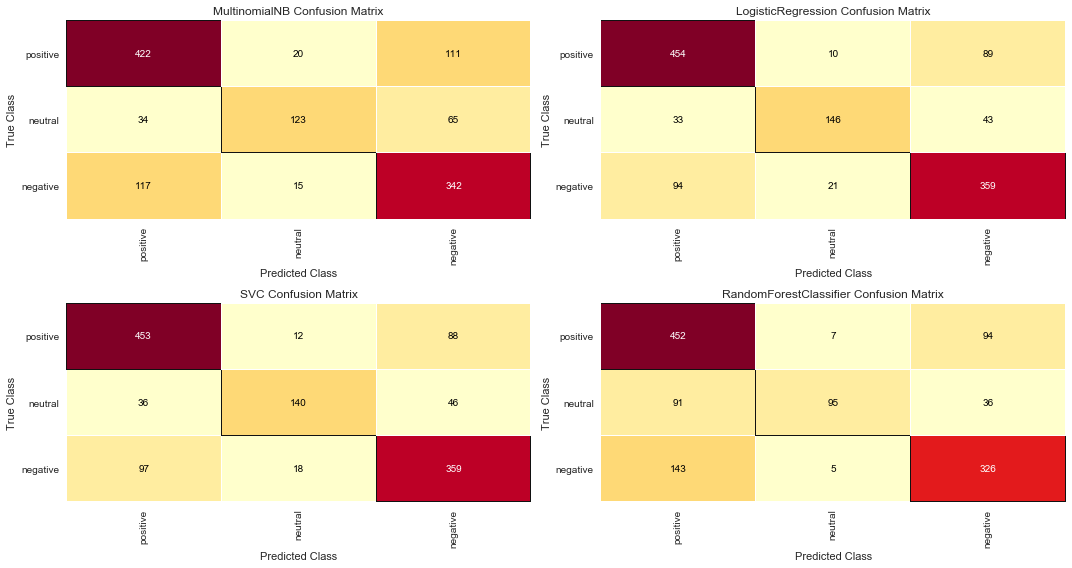

In [144]:
fig, ax = plt.subplots(2,2, figsize=(15,8), tight_layout=True)

visualgrid = [
    ConfusionMatrix(model=mnb, classes=classes, ax=ax[0,0]),
    ConfusionMatrix(model=lr, classes=classes, ax=ax[0,1]),
    ConfusionMatrix(model=svm, classes=classes, ax=ax[1,0]),
    ConfusionMatrix(model=rf, classes=classes, ax=ax[1,1])
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()


### ROCAUC curve
tradeoff between the model’s sensitivity and specificity

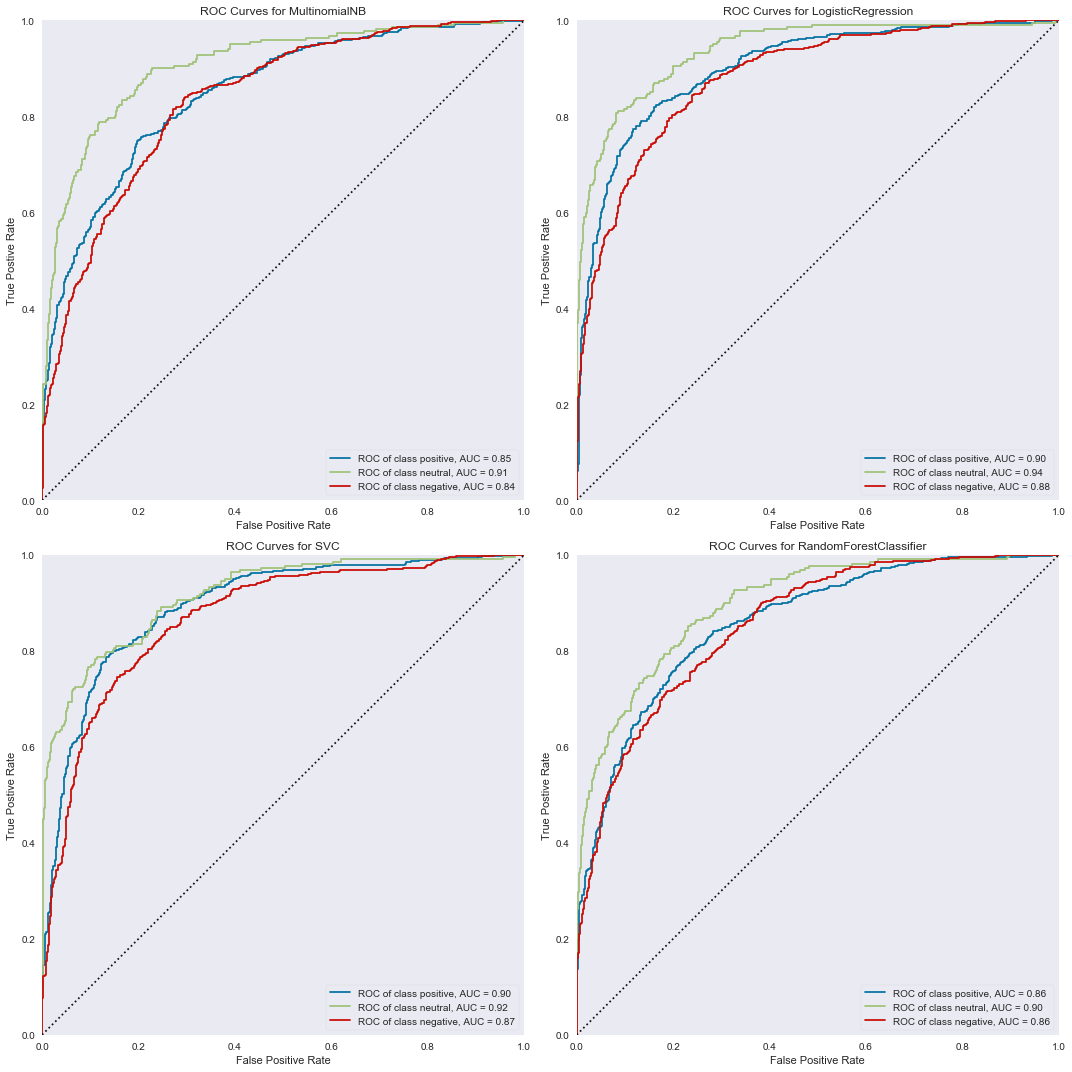

In [143]:
fig, ax = plt.subplots(2,2, figsize=(15,15), tight_layout=True)

visualgrid = [
    ROCAUC(model=mnb, classes=classes, ax=ax[0,0], micro=False, macro=False),
    ROCAUC(model=lr, classes=classes, ax=ax[0,1], micro=False, macro=False),
    ROCAUC(model=svm, classes=classes, ax=ax[1,0], micro=False, macro=False),
    ROCAUC(model=rf, classes=classes, ax=ax[1,1], micro=False, macro=False)
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    for label in viz.ax.texts:
        label.set_size(15)
    viz.finalize()


### Classification reports
Report on the accuracy of the classifier

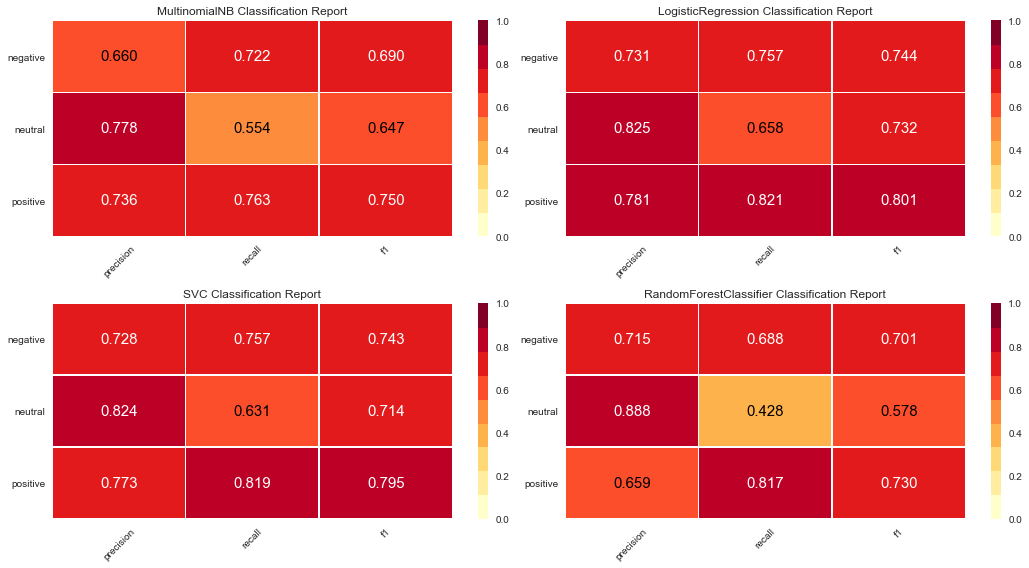

In [145]:
fig, ax = plt.subplots(2,2, figsize=(15,8), tight_layout=True)

visualgrid = [
    ClassificationReport(model=mnb, classes=classes, ax=ax[0,0]),
    ClassificationReport(model=lr, classes=classes, ax=ax[0,1]),
    ClassificationReport(model=svm, classes=classes, ax=ax[1,0]),
    ClassificationReport(model=rf, classes=classes, ax=ax[1,1])
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    for label in viz.ax.texts:
        label.set_size(15)
    viz.finalize()
